# Bienvenido
## App: TrendingTopic

**INFORMACION RESPECTO A LOS OUTPUTS**

- Dentro de la carpeta **jovyan/outputs/** se guarda la salida del código

In [1]:
import os
import multiprocessing

import warnings
warnings.filterwarnings('ignore')

In [2]:
archivo = "debate-oct.csv"

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Longitud del dataset instagram: 17124
Complete. Number of Instagram comments that have been cleaned and tokenized: 17117
Total number of Tokens : 190688
Preprocess done in 8.938 s
Tiempo de tokenizacion: 8.94 seconds

Gerenciamiento de directorios -  jovyan:
Se crea el directorio jovyan/outputs en ubicación:
/home/jovyan/Debate Presidentes/jovyan/outputs



Output path: jovyan/outputs/1



Se crea el directorio jovyan/outputs/1 en ubicación:
/home/jovyan/Debate Presidentes/jovyan/outputs/1

tf topic model: 

Instanciación correcta
Entrenamiento y prediccion correcta




Process done in 2.325 s
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.54046108e-06 1.79306180e-04 4.03545700e-05 1.96065135e-04]
 ...
 [1.02686951e-04 4.89018937e-06 2.77188210e-05 1.00704016e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Process done in

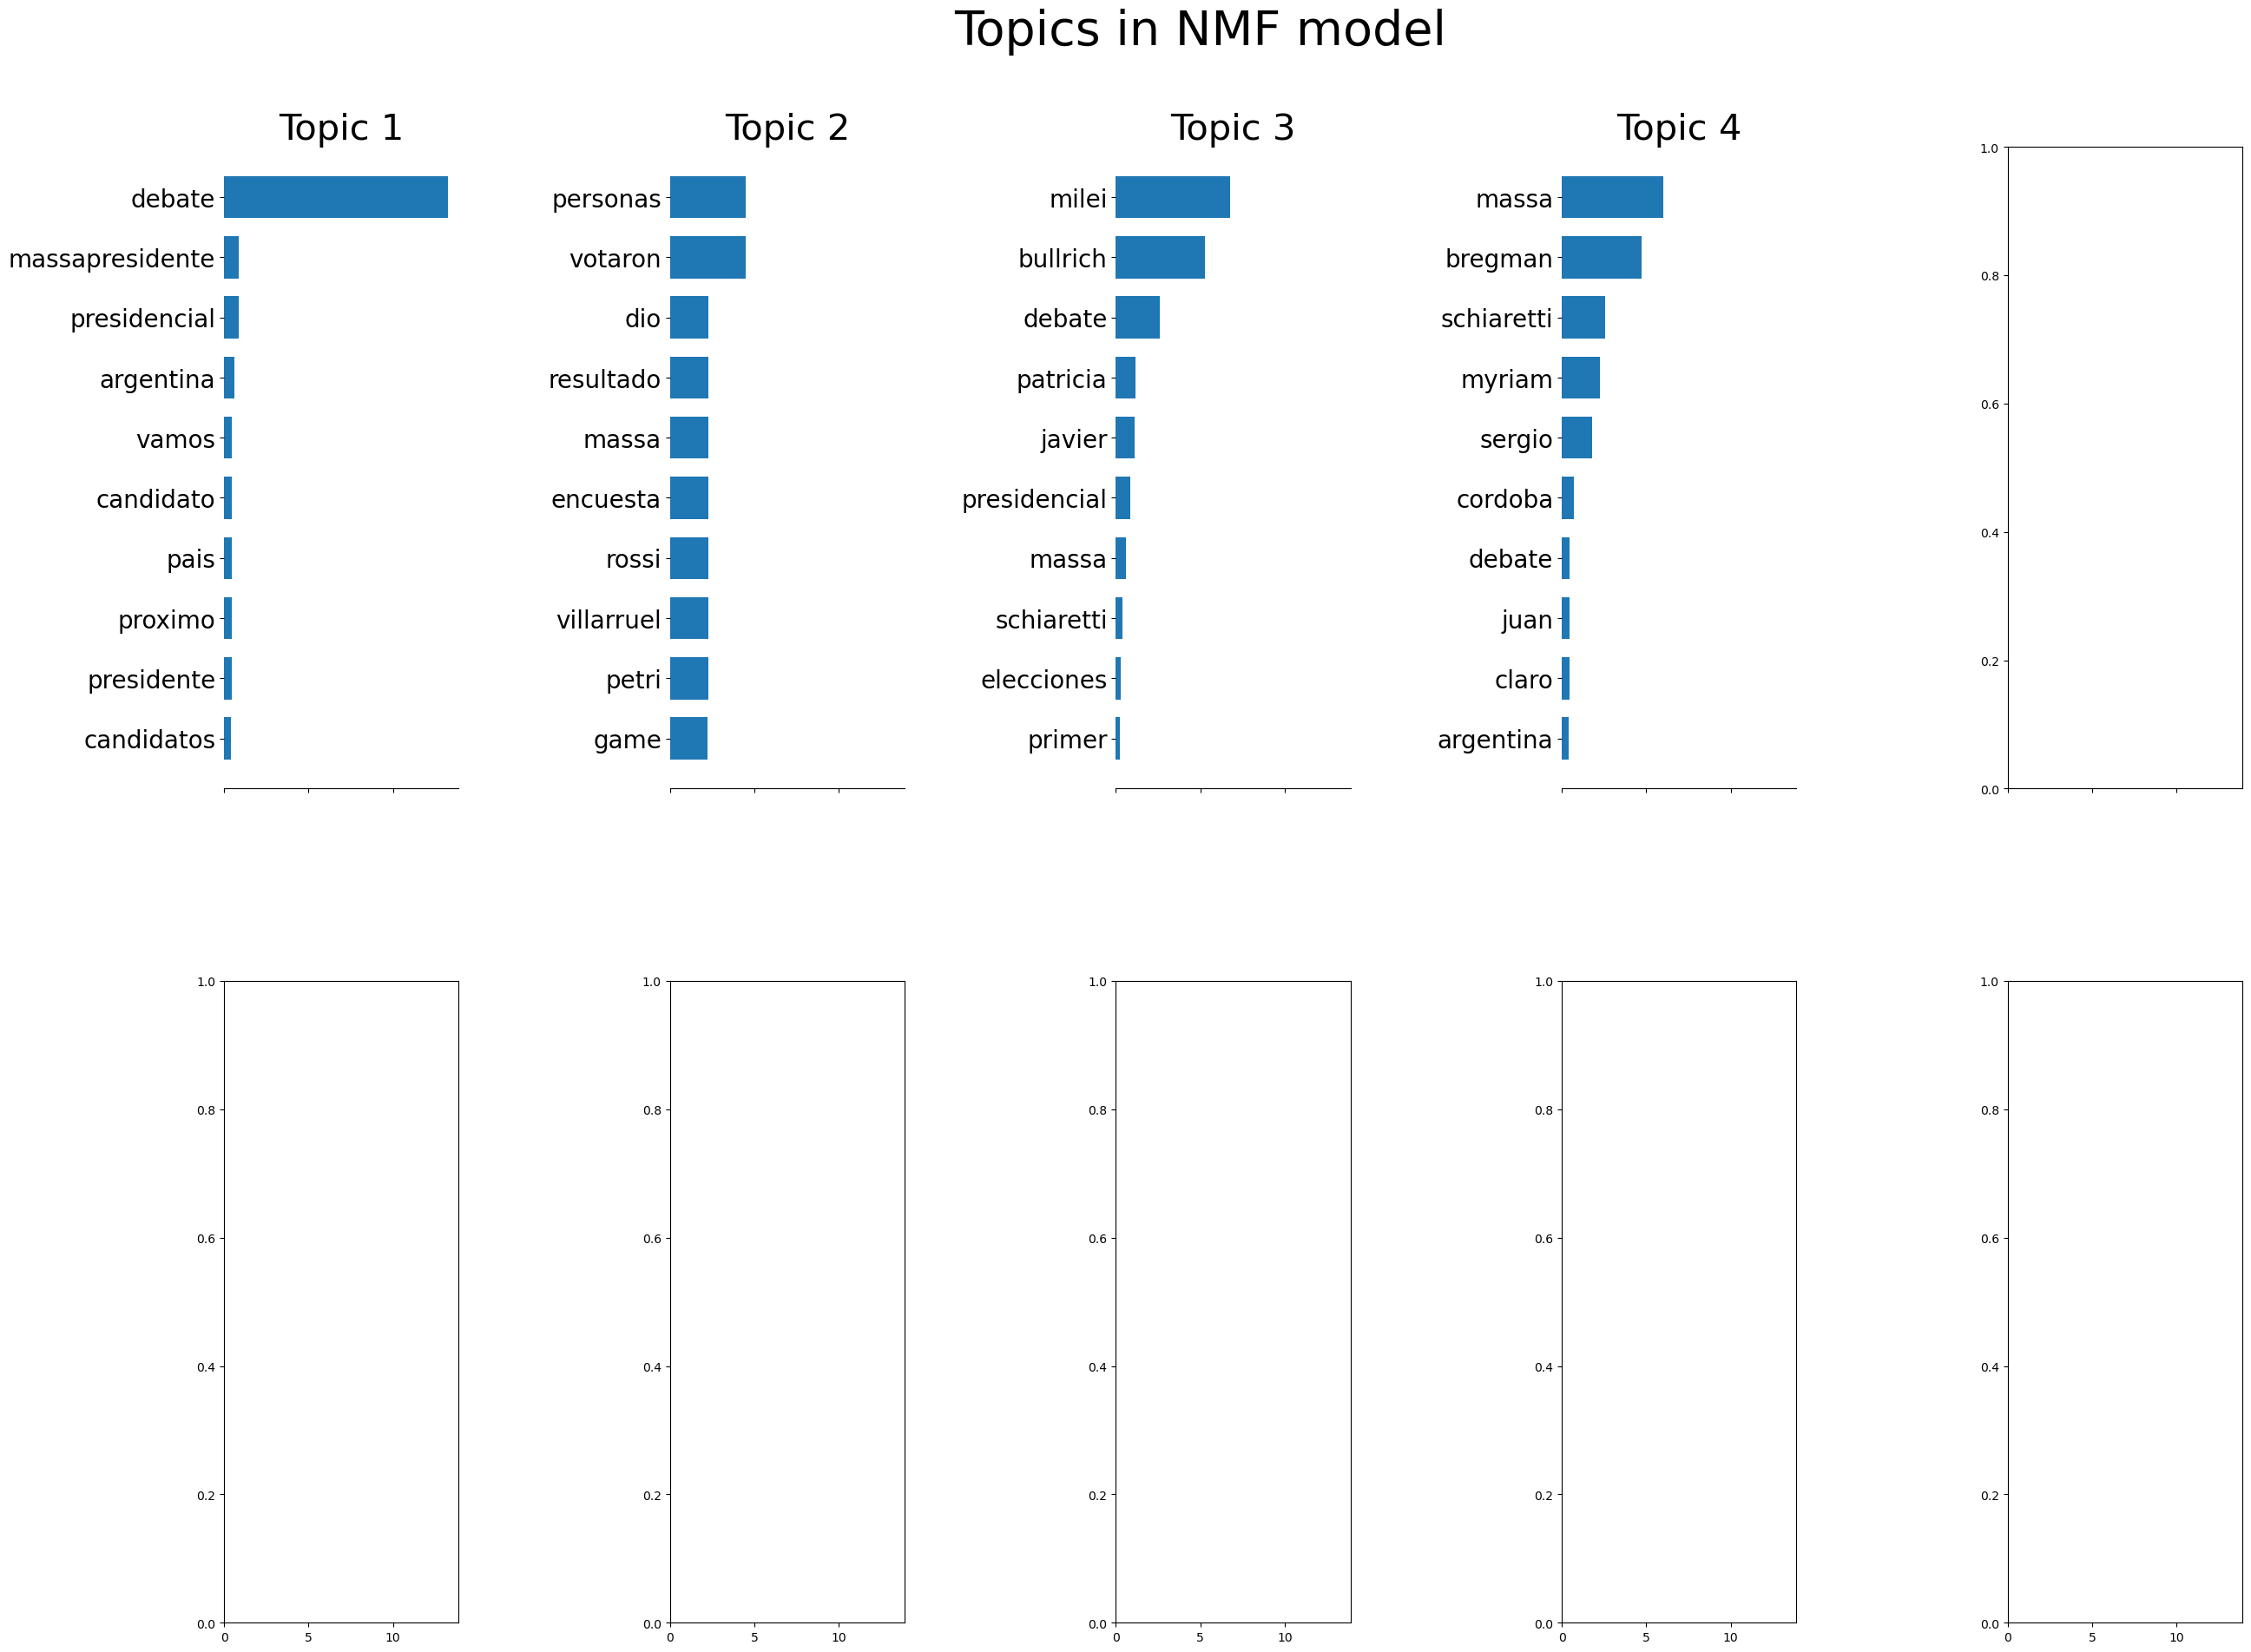

In [3]:
from app.TrendingTopic import feed_instagram as fi
from app.TrendingTopic.topic_detection import topicDetection as td
from tools.feed import data_info, crear_directorio, nombrar_subfolder_numerada

from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

if __name__ == "__main__":


    multiprocessing.freeze_support()

    verbose = False
    df_puc_op = fi.main(archivo)


    # Definicion de directorios
    project_path =  os.path.dirname(os.path.realpath("."))
    project_name = project_path.split("/")[-1]

    output_path = f"{project_name}/outputs"
    



    # Configuración del directorio de salida - la descarga se hace en el directorio del proyecto
    print(f"\nGerenciamiento de directorios -  {project_name}:")

    # print(f"\n\nhello world\nOutput path: {output_path}\n")
    crear_directorio(output_path)
    path_output_N = nombrar_subfolder_numerada(output_path)
    if path_output_N.endswith("-inf"):
        path_output_N = path_output_N[:-5]
    print(f"\n\n\nOutput path: {path_output_N}\n\n\n")

    crear_directorio(path_output_N)
    # crear_directorio(backup_path)
    print()


    ## EMBEDDINGS
    corpus_puc_op = df_puc_op["tokens"]

    dictionary_puc_op = td.corpora.Dictionary(corpus_puc_op)
    bow_puc_op = [
        dictionary_puc_op.doc2bow(text) for text in corpus_puc_op
    ]




    # Determinación de la cantidad de temas
    max_coherence_score = 0
    best_num_topics = 0

    if verbose:
        print("\n\nIngresando al bucle de detección de Cantidad temas")
    for i in range(4, 11):
        if verbose:
            print("Creando modelo LSI: {}".format(i))
        lsi = LsiModel(bow_puc_op, num_topics=i, id2word=dictionary_puc_op)
        if verbose:
            print("Calculando Coherence Score")
        coherence_model = CoherenceModel(
            model=lsi,
            texts=df_puc_op["tokens"],
            dictionary=dictionary_puc_op,
            coherence="c_v",
        )
        coherence_score = coherence_model.get_coherence()

        if verbose:
            print("Coherence score with {} clusters: {}".format(i, round(coherence_score, 4)))
        if coherence_score > max_coherence_score:
            max_coherence_score = coherence_score
            best_num_topics = i

    if verbose:
        print("Best number of topics: {}".format(best_num_topics))



    # TEMAS SELECCIONADOS
    data = df_puc_op.tokens.to_list()


    ### Implementacion de CountVectorizer

    nmf_puc_op = td.nmf_topic_model(
        model="tf",
        data=data,
        PATH=path_output_N,
        n_topics=best_num_topics,
        max_iter=1000,
        min_df=1,
        max_df=1.0,
        n_top_words=10,
        stop_words=td.stop_words,
        token_pattern=r"\w+",
        beta_loss="kullback-liebler",
    )

    array_topicos = td.get_topics(model='tf', data=df_puc_op['content'], n_topics= best_num_topics,\
                                  max_iter=1000, min_df=10, max_df=300, n_top_words = 10,\
                        stop_words=td.stop_words, token_pattern=r'\w+', beta_loss="kullback-liebler")


    topicos = []
    for i in array_topicos:
        topico = f"topico {i + 1}"
        topicos.append(topico)



    df_puc_op['topics'] = topicos
    df_puc_op.to_csv(f"{path_output_N}/classificated_topics.csv")#TODO: CAMBIAR PATH - to csvs_junk 
    if False:
        verbose_path = f"{project_name}/df_puc_op_topics"
        print(f"Guardando salida en: {verbose_path}.pickle\n")
        with open(verbose_path+".pickle", "wb") as f:
            # pickle.dump(df_puc_op, f)
            df_puc_op.to_feather(verbose_path+".feather")

